In [103]:
%reload_ext autoreload
%autoreload 2

%reload_ext autoreload
%autoreload 2
import sys; sys.path.append('..')
from src.data_utils import get_dataset_imagenet, imagenet_classes
from jupyter_preproc import smoothen_all, probs_to_softacc
import numpy as np
import time
import matplotlib.pyplot as plt
rng = np.random.default_rng(5)

In [9]:
val_npz_path = '/home/jupyter/processed/imagenet/resnet50/resnet50_imagenet_val.npz'

In [10]:
imagenet_val = np.load(val_npz_path)

In [14]:
for key in imagenet_val.keys():
    print(key)

x
all_acc
x_err
all_acc_err
points
points_err
labels
labels_err
probs
freqs


In [16]:
imagenet_val['points'].shape

(50000, 40)

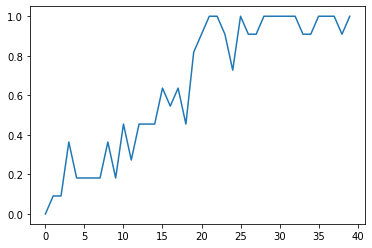

In [26]:
plt.plot(imagenet_val['points'][5])

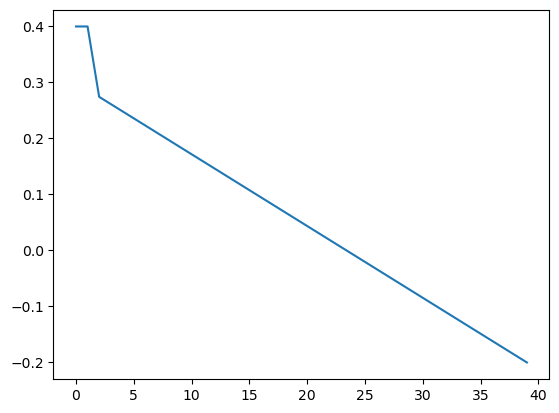

In [161]:
weight = np.linspace(0.3, -0.2, 40)
weight[0] = 0.4
weight[1] = 0.4
plt.plot(weight)

In [162]:
normalized_accs = imagenet_val['points']
normalized_accs = (normalized_accs - normalized_accs.min(axis=1)[:, None]) / np.maximum((normalized_accs.max(axis=1) - normalized_accs.min(axis=1))[:, None], 1e-4)


In [163]:
weighted = normalized_accs * weight[None]

In [164]:
score = weighted.sum(1)

In [165]:
j = 0
score_ids = score.argsort()[::-1]

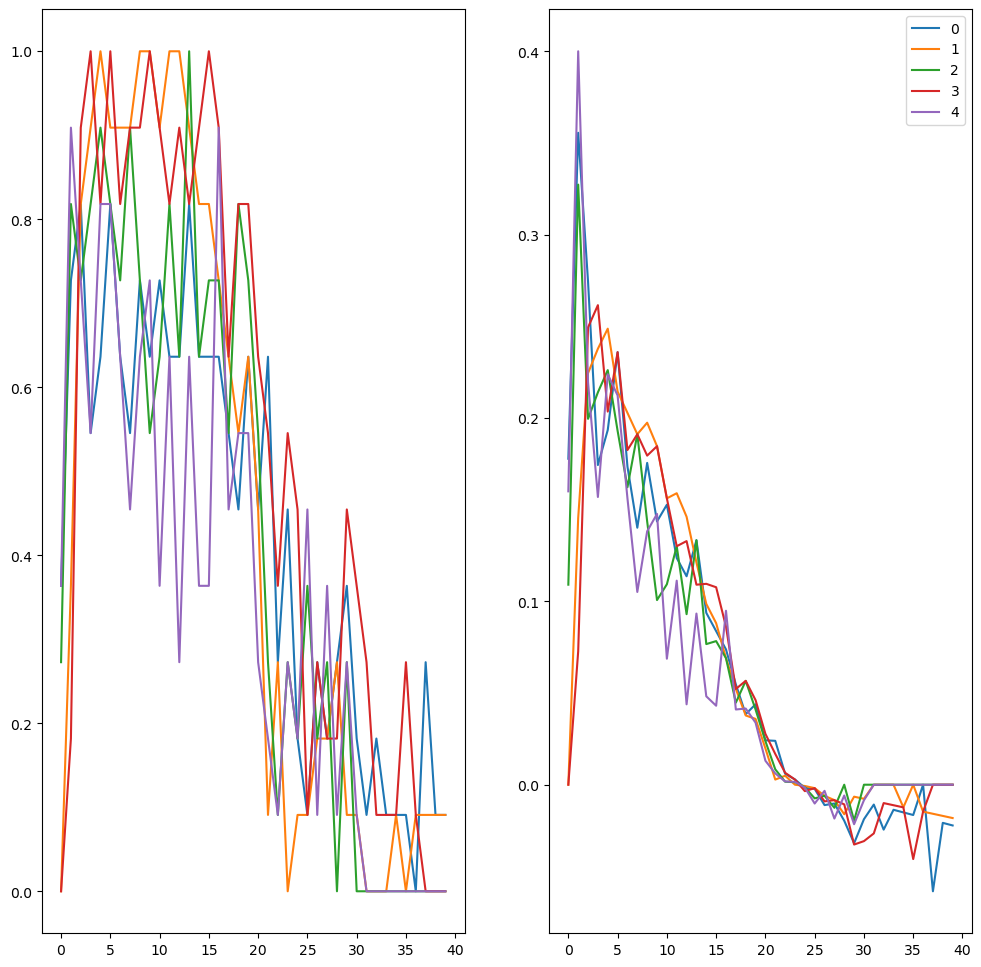

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
for i in range(j, j+5):
    axes[0].plot(imagenet_val['points'][score_ids[i]], label=f'{i}')
    axes[1].plot(weighted[score_ids[i]], label=f'{i}')
plt.legend()
j+=5

In [167]:
score_ids

array([48685, 39660, 49177, ..., 38933, 29464, 35323])

In [124]:
def get_dataset_imagenet(val_name):  
    from torchvision import datasets
    from torchvision.transforms import transforms
    default_data_paths = {
    'imagenet_val': '/home/jupyter/dist-shift/data/imagenet-val/',
    'imagenet_a': '/home/jupyter/dist-shift/data/...',
    'imagenet_r': '/home/jupyter/dist-shift/data/...',
    'imagenet_sketch': '/home/jupyter/dist-shift/data/sketch',
    'imagenet_v2': '/home/jupyter/dist-shift/data/...'
    }
    if val_name not in ['imagenet_val', 'imagenet_sketch']:
        raise NotImplementedError()
    datapath = default_data_paths[val_name]
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return datasets.ImageFolder(datapath, test_transforms)

In [125]:
dataset = get_dataset_imagenet('imagenet_val')
ytest = dataset.targets

In [116]:
G = imagenet_val
classes = imagenet_classes

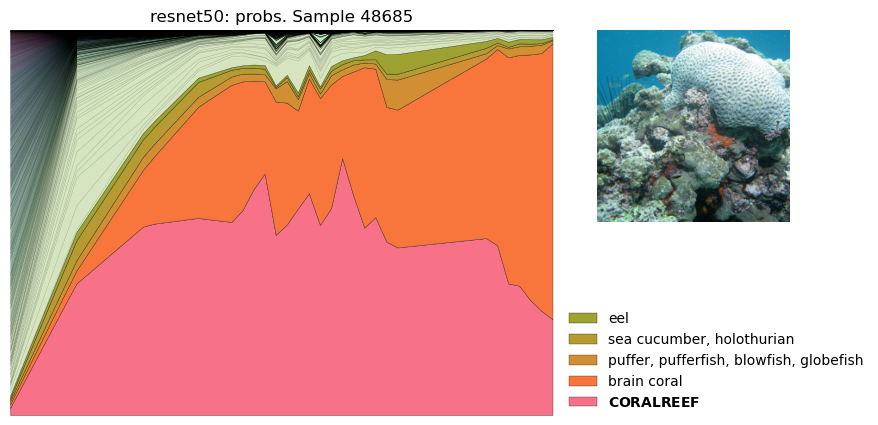

In [127]:
import seaborn as sns
import matplotlib as mpl
from scipy.interpolate import interp1d

gname = 'resnet50'
dname = 'imagenet_val' # or imagenet_sketch


def std_single(Gi, x, gridpts, t="probs", smooth=False, sigma=2.0):
    """
        Return a "standard form" for the stackplots.
        Gi : (NUM_LABELS, NUM_CHECKPOINTS)
        x : the input x-axis (of Gi)
        gridpts : the output x-axis (to standardize wrt)
    """
    xx = gridpts
    res = []
    for j, y in enumerate(Gi):
        # linearly interpolate the curve on uniform grid
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        if smooth:
            yy = gaussian_filter1d(yy, sigma=sigma) # note that this doesn't mess up the probability simplex
        res.append(yy)
    return np.array(res)

def stacksimple(i, x, prof, topk=5, ax=None):
    """
        i: index of image in dataset
        x: x-axis points
        prof: profile (NUM_LABELS, len(x))
        topk: number of "main" labels, for the legend.
    """
    true_label = ytest[i]
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals

    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        f, ax = plt.subplots(figsize=(7, 5))
        # f, ax = plt.subplots(figsize=(3, 2))
    
    # colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    # cm = sns.color_palette('rainbow', as_cmap=True)
    # fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    # colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    cp = 0.3 # fraction of color space to take up with topk
    c1, c2 = np.linspace(0, cp, topk, endpoint=False), np.linspace(cp, 1, len(ind)-topk)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    cm = sns.color_palette('husl', as_cmap=True)
    colors = [cm(v) for v in c1] + [fix_alpha(cm(v)) for v in c2]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.2))
        s.set_linewidth(0.2)

    for s in stacks[:topk]:
        s.set_edgecolor((0,0,0, 0.7))
        s.set_linewidth(0.3)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' '), labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    ax.set_axis_off()  
    sns.despine()
    
    ax2 = ax.inset_axes([1.01, 0.5, 0.5, 0.5], aspect='equal')
    ax2.set_axis_off()
    ax2.imshow(dataset[i][0].numpy().transpose(1,2,0))
    
    return ax.figure

## parameters
t = 'probs'
smooth = True
gridpts = 50 # num pts on x-axis

## generate plot
xkey = 'x'
x = G[xkey]

xx = np.linspace(x.min(), x.max(), gridpts) # output x-axis

i = 48685
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'

# yy = G[t][i]

yy = std_single(G[t][i], x, gridpts=xx, t=t, smooth=False) ## standardize (uniform x-axis)
    
f = stacksimple(i, xx, yy) # the actual plot
f.axes[0].set_title(f'{gname}: {t}. Sample {i}');



In [168]:
score_ids

array([48685, 39660, 49177, ..., 38933, 29464, 35323])

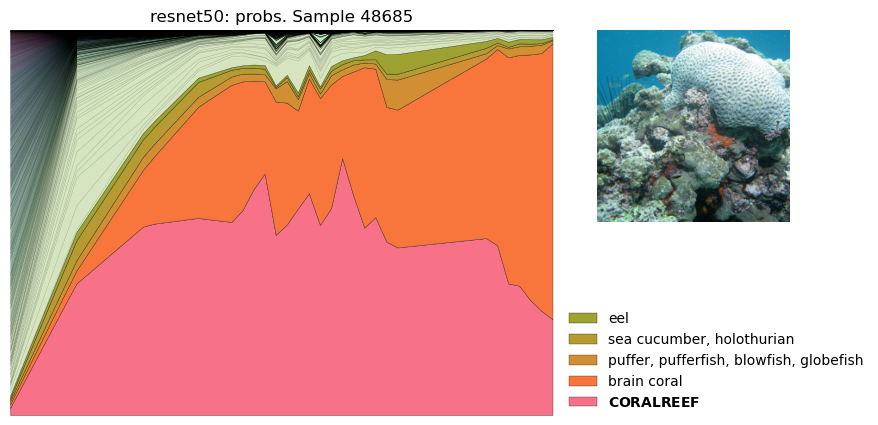

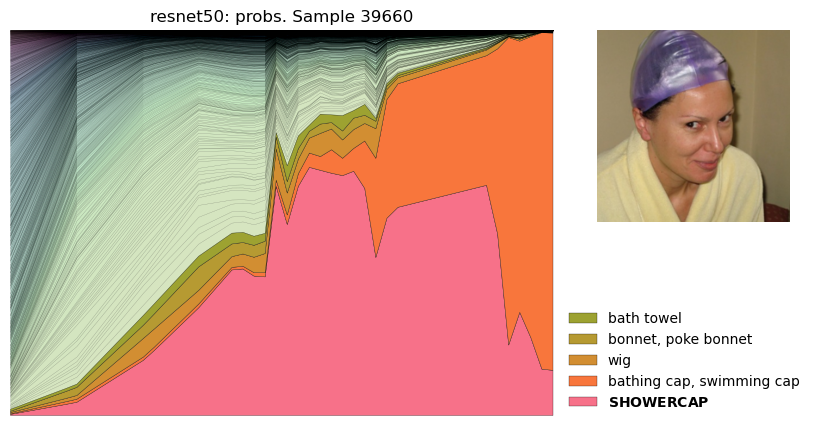

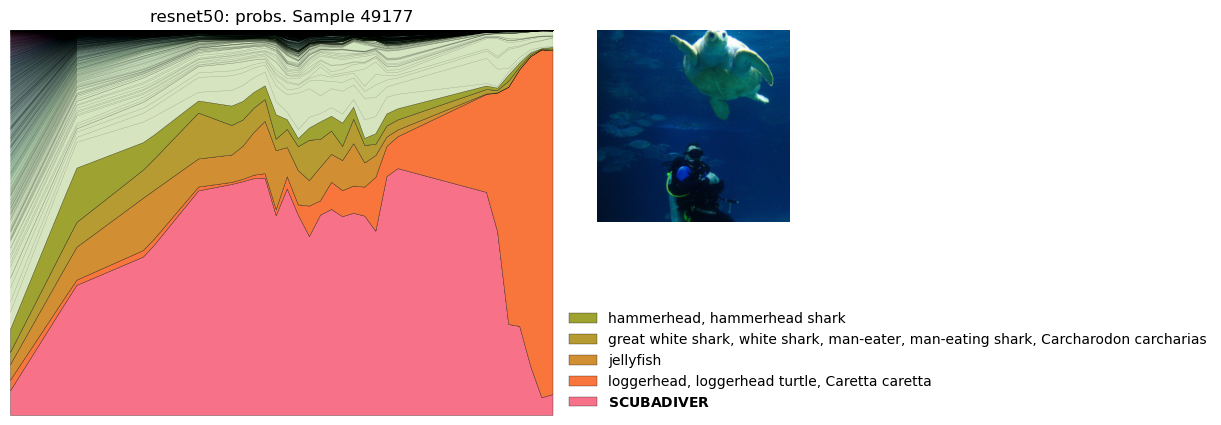

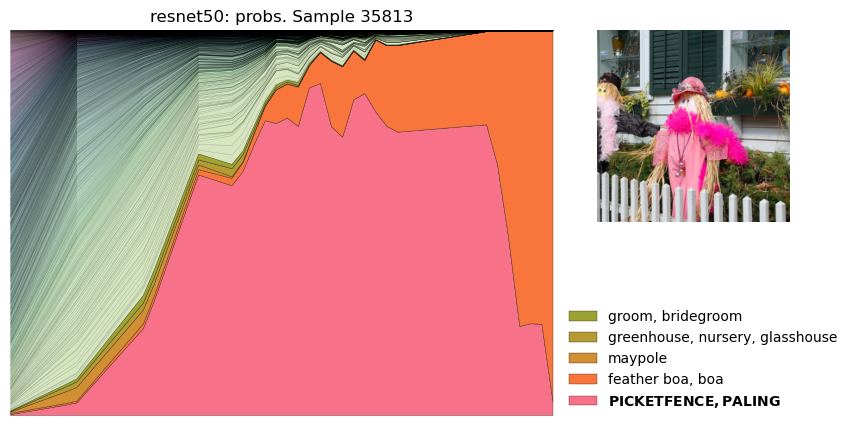

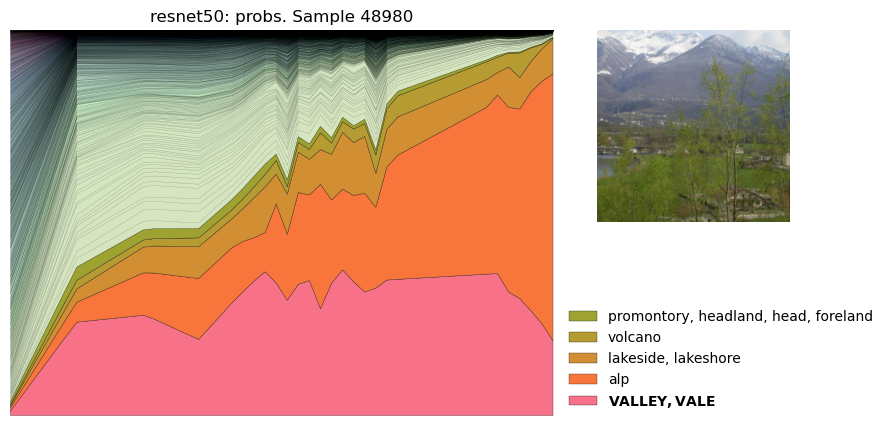

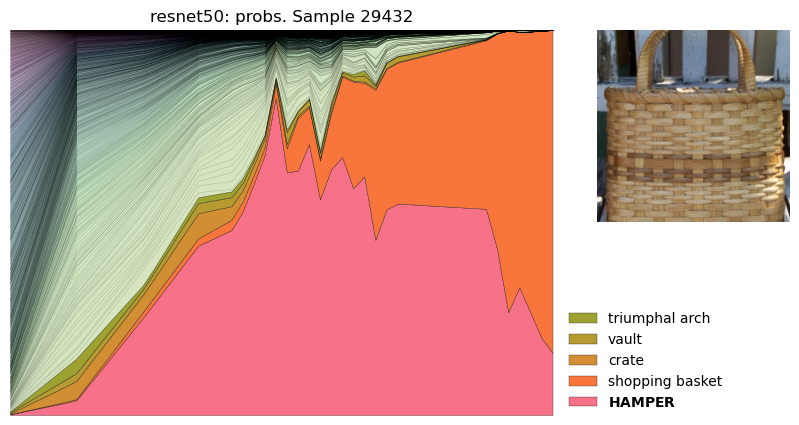

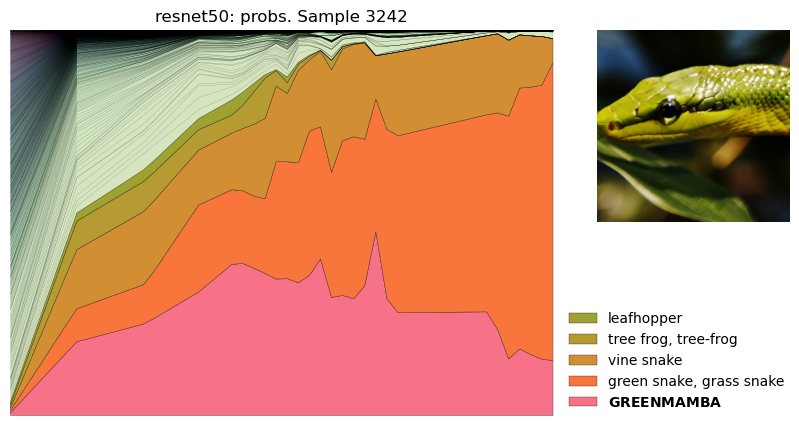

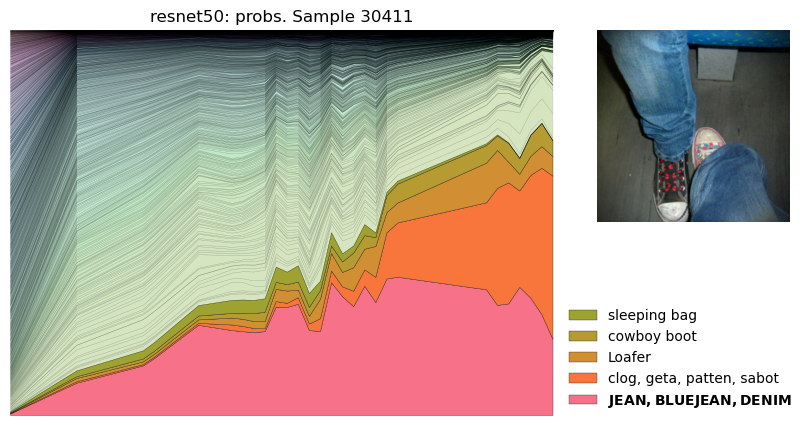

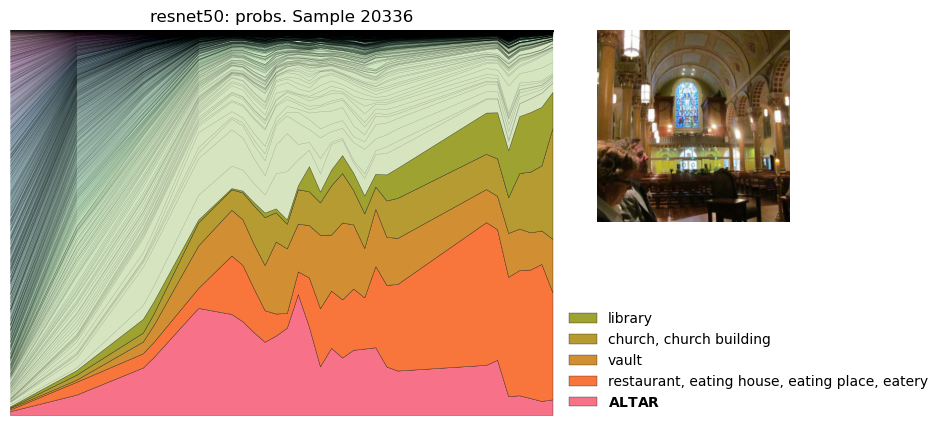

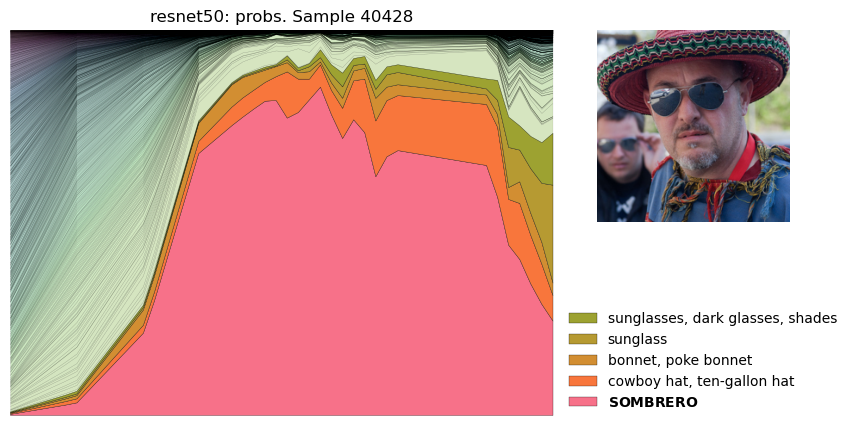

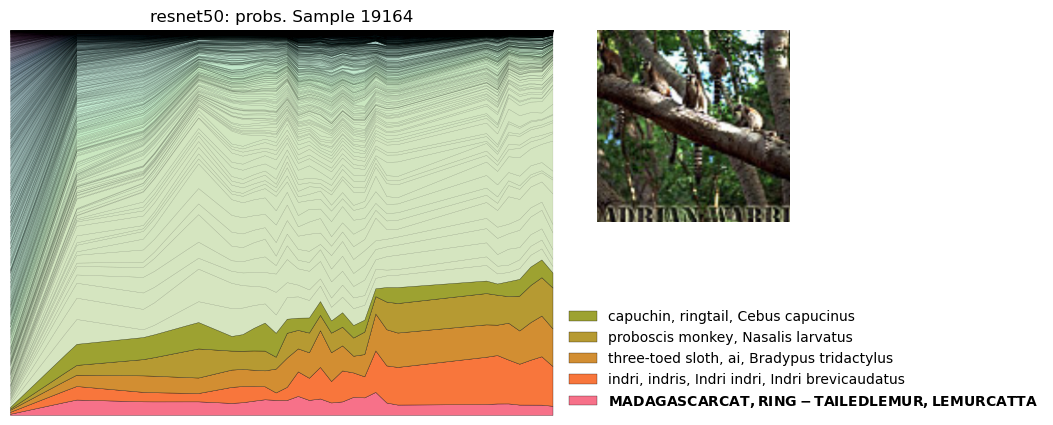

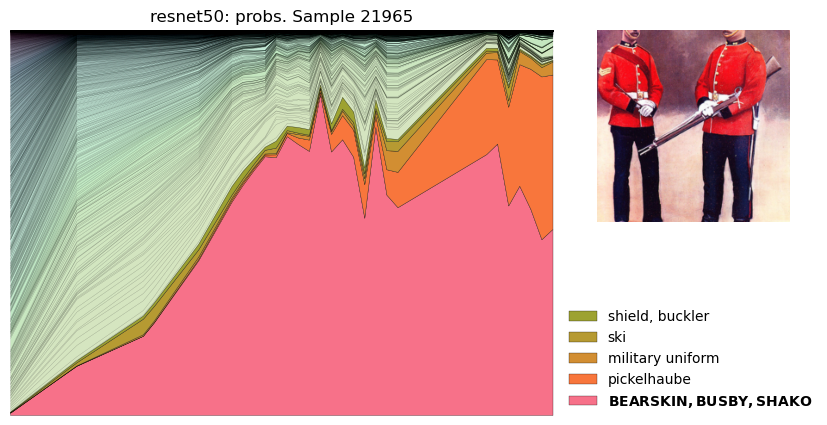

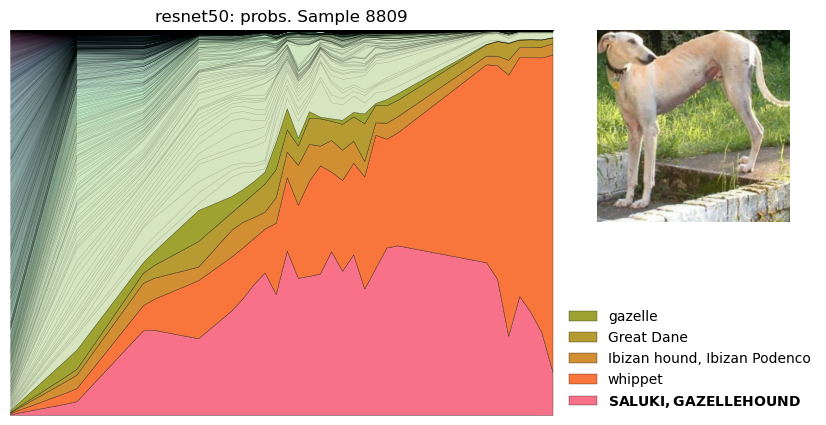

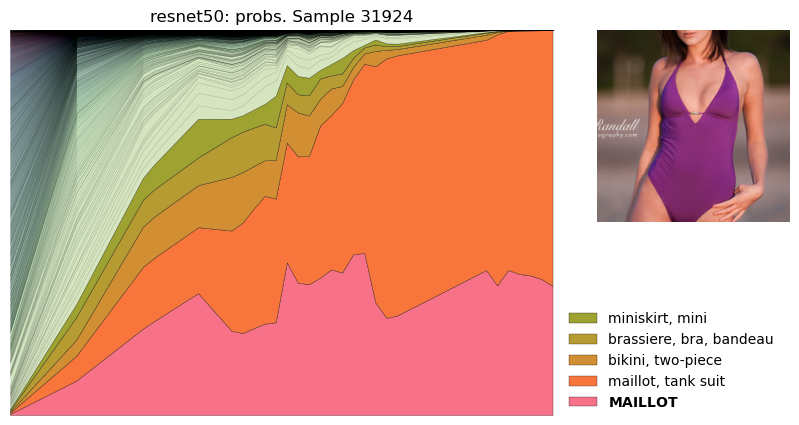

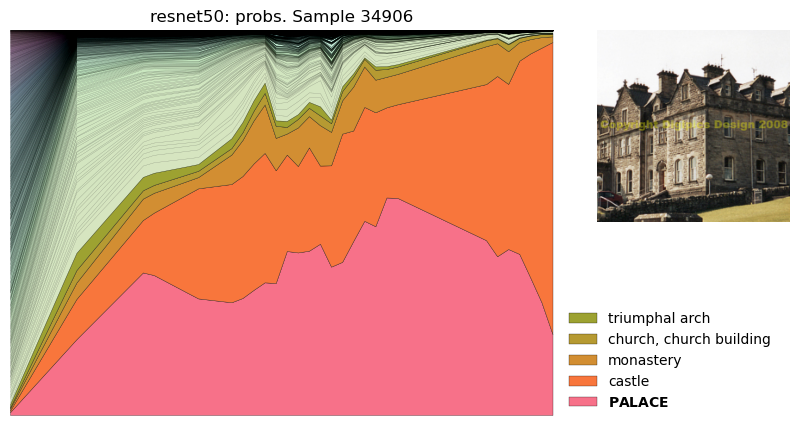

In [170]:
for i in score_ids[:15]:
    yy = std_single(G[t][i], x, gridpts=xx, t=t, smooth=False) ## standardize (uniform x-axis)
    
    f = stacksimple(i, xx, yy) # the actual plot
    f.axes[0].set_title(f'{gname}: {t}. Sample {i}');
    plt.show()
    

In [171]:
! df -h .

Filesystem      Size  Used Avail Use% Mounted on
/dev/sdb        246G  167G   79G  68% /home/jupyter
